In [ ]:
# in this notebook we will explore the use of various time-series forecasting algorithms
# on different data sets. We will begin by performing some exploratory data analysis and then try to fit some models
# and produce some forecasts and validation. 

In [298]:
# let's begin with an popular example of a time-series: a stock price over time.

# Load the AMZN stock price data from https://www.nasdaq.com/market-activity/stocks/amzn/historical

import csv
import numpy as np

df = pd.read_csv("./HistoricalData_AMZN.csv")
price=df['Close/Last'].str.replace('$', '').astype(np.float)

/var/folders/dx/6wlm8t016fzf99_mpkrjx0280000gn/T/ipykernel_16820/3715872018.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  price=df['Close/Last'].str.replace('$', '').astype(np.float)
/var/folders/dx/6wlm8t016fzf99_mpkrjx0280000gn/T/ipykernel_16820/3715872018.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  price=df['Close/Last'].str.replace('$', '').astype(np.float)


In [299]:
from statsmodels.tsa.stattools import adfuller

# perform Augmented Dickey-Fuller Test to see if series follows a random walk.
# output is test stat, p-value, and critical values for 0.01, 0.1, and 0.05 levels
results = adfuller(price)
print(results)
print(results[1]) #p-value

#With the ADF test, the "null hypothesis" is that the series follows a random walk. 
#Therefore, a low p-value (say less than 5%) means we can reject the null hypothesis that the series is a random walk
#our p-value is very low, the stock price is clearly a random walk then. No surprises there.

#stock price will be too hard to model, if it is even possible given that it is so close to a random walk, therefore
#we'll look to some other data sets

(-1.2617995169943363, 0.6464629348124871, 27, 2488, {'1%': -3.4329810529006184, '5%': -2.862702382731847, '10%': -2.5673887817601657}, 24112.527033711085)
0.6464629348124871


In [ ]:
# here we will explore the dataset provided by Wikipedia to a 
# Kaggle competition: https://www.kaggle.com/c/web-traffic-time-series-forecasting
# it provides data for the number of page visits over time for various pages, we'll look at just one page here

import csv
import pandas as pd

df = pd.read_csv("./wiki_data.csv") # import wiki

(-8.884037701518485, 1.2946704090247951e-14, 3, 546, {'1%': -3.442383534871275, '5%': -2.8668480382580386, '10%': -2.569597004924258}, 5075.295013583333)
1.2946704090247951e-14


<AxesSubplot:>

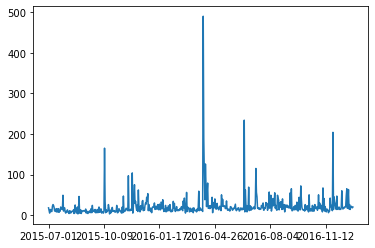

In [89]:
from statsmodels.tsa.stattools import adfuller

# perform Augmented Dickey-Fuller Test to see if series follows a random walk.
# output is test stat, p-value, and critical values for 0.01, 0.1, and 0.05 levels
results = adfuller(df.iloc[0][1:]) #look at just the first page
print(results)
print(results[1]) #p-value

#With the ADF test, the "null hypothesis" is that the series follows a random walk. 
#Therefore, a low p-value (say less than 5%) means we can reject the null hypothesis that the series is a random walk
#our p-value is very low, clearly not a random walk then.
df.iloc[0][1:].plot() #data looks stationary

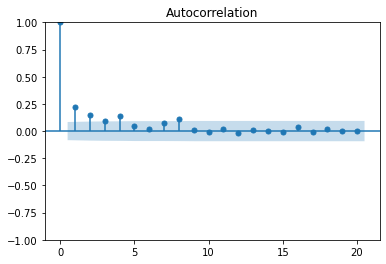

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(df.iloc[0][1:], lags=20) #compute the auto-correlation function
plt.show()

# lags 1 and maybe 2,4 are significant

/Users/leonruocco/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


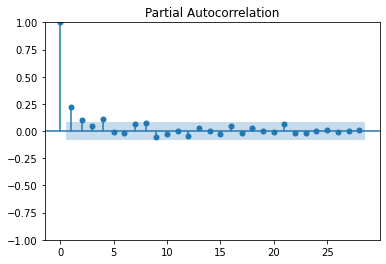

In [19]:
# let's try an ARMIA model
# this is an auto-regressive model using its own lags as predictors so we need a stationary model, which we have 

#ARIMA takes 3-input parameters
#d=number of differncing to make stationary (already stationart so d=0)
#‘p’ is the order of the ‘Auto Regressive’ (AR) term referring to the number of lags of Y to be used as predictors
#‘q’ is the order of the ‘Moving Average’ (MA) term. It refers to the number of lagged forecast errors 
#that should go into the ARIMA Model.

#to determine p we inspect the partial-autocorrelation function (PACF)
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df.iloc[0][1:])
plt.show() #probs just lag 1 significant

#q is determined from the acf (above) which we determined to be q=1(or maybe 2)

In [95]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

web_page_time_series = list(df.iloc[num][1:]) # ARIMA needs a list input even though documentation says array nvrmnd
# 0,1,2 ARIMA Model
model = ARIMA(web_page_time_series, order=(0,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  550
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -2400.943
Date:                Tue, 15 Mar 2022   AIC                           4807.885
Time:                        14:47:22   BIC                           4820.809
Sample:                             0   HQIC                          4812.936
                                - 550                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9078      0.039    -23.055      0.000      -0.985      -0.831
ma.L2         -0.0365      0.038     -0.954      0.340      -0.111       0.038
sigma2       366.7747      3.274    112.028      0.0

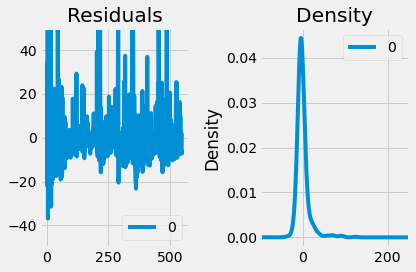

In [121]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
ax1=ax[0]
ax2=ax[1]
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax1.set_ylim([-50, 50])
ax2.set_xlim([-100, 250])
fig.tight_layout() #improve separation
plt.show()

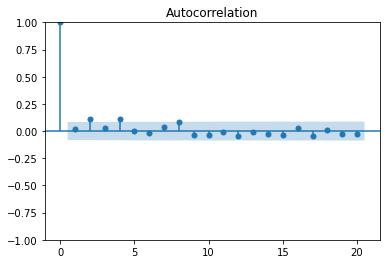

In [40]:
# from the residuals it seems the mean is not zero and there are large unexpected jumps. 
# density is also skewed from a noraml distribution further suggestion the model fit is not great

plot_acf(residuals, lags=20)
plt.show()
# a plot of the acf of the residuals indicates a slight correlation between residuals but too bad

In [83]:
from statsmodels.tsa.api import ARIMA

train_dates=df.iloc[0][1:].index[:int(train_ratio*len(web_page_time_series))]
test_dates=df.iloc[0][1:].index[int(train_ratio*len(web_page_time_series)):]
forecast_dates=pd.to_datetime(pd.date_range(str(test_dates[-1]), periods=num_days_forecast, freq="D")).tz_localize(None)

# training and test split
train_ratio=0.9
train = web_page_time_series[:int(train_ratio*len(web_page_time_series))]
test = web_page_time_series[int(train_ratio*len(web_page_time_series)):]

#build model again but on train data only
model = ARIMA(train, order=(0,1,2))
model_fit = model.fit()
print(model_fit.summary())

# forecast
num_days_forecast=len(test_dates)
forecast = model_fit.get_forecast(num_days_forecast)  # 95% conf
forecast_series = forecast.summary_frame()['mean']

yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05) #get 95% confidence intervals

#confidence interval bounds
lower_conf_int = yhat_conf_int[:,0]
upper_conf_int = yhat_conf_int[:,1]

print(forecast.summary_frame().index)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  495
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -2358.746
Date:                Tue, 15 Mar 2022   AIC                           4723.492
Time:                        14:36:11   BIC                           4736.099
Sample:                             0   HQIC                          4728.442
                                - 495                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7879      0.022    -35.581      0.000      -0.831      -0.745
ma.L2         -0.1822      0.024     -7.695      0.000      -0.229      -0.136
sigma2       817.4856      6.003    136.172      0.0

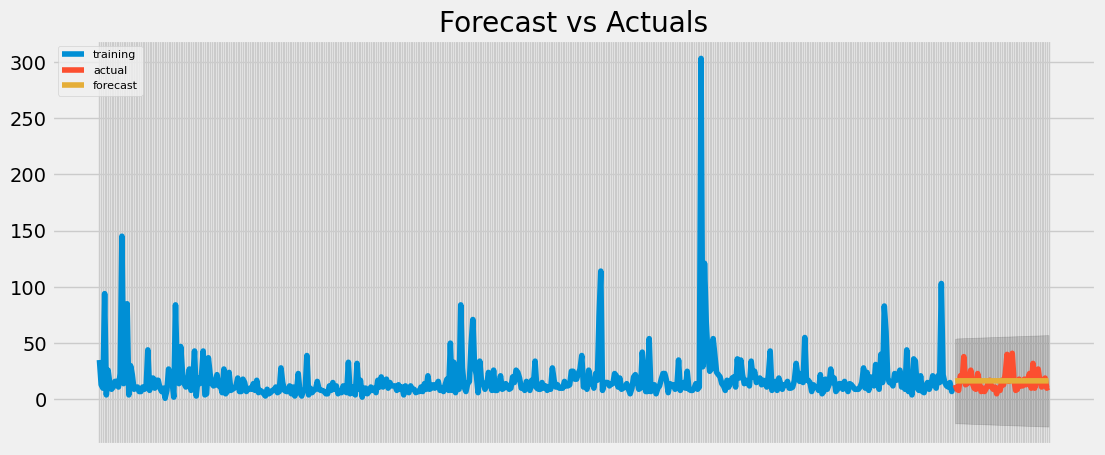

In [122]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_dates,train, label='training')
plt.plot(test_dates,test, label='actual')
plt.plot(test_dates,forecast_series, label='forecast')
plt.fill_between(test_dates,lower_conf_int, upper_conf_int, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
# plt.ylim([0, 100])
# plt.xlim([test_dates[0], test_dates[-1]])
plt.show()

In [ ]:
# hard to tell how useful this forecast really is. We'll test our model's performance later, but for now let's
# see about changing our input parameters to ARIMA. Actually instead of manually playing with these numbers we can
# use the pmdarima library's built in functionality to automate this for us.

In [ ]:
!pip install pmdarima

In [99]:
# here we try auto_arima which will find the optimal values of p,q,d for us

from statsmodels.tsa.api import ARIMA
import pmdarima as pm

train_dates=df.iloc[num][1:].index[:int(train_ratio*len(web_page_time_series))]
test_dates=df.iloc[num][1:].index[int(train_ratio*len(web_page_time_series)):]
# forecast_dates=pd.to_datetime(pd.date_range(str(test_dates[-1]), periods=num_days_forecast, freq="D")).tz_localize(None)

# training and test split
train_ratio=0.9
train = web_page_time_series[:int(train_ratio*len(web_page_time_series))]
test = web_page_time_series[int(train_ratio*len(web_page_time_series)):]

#use auto_arima to loop through p,q,d and find optimal values by minimising the AIC
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal )
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

# model_fit = model.fit()
print(model_fit.summary())

# forecast
num_days_forecast=len(test_dates)
forecast = model_fit.get_forecast(num_days_forecast)  # 95% conf
forecast_series = forecast.summary_frame()['mean']

yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05) #get 95% confidence intervals

#confidence interval bounds
lower_conf_int = yhat_conf_int[:,0]
upper_conf_int = yhat_conf_int[:,1]

print(forecast.summary_frame().index)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4363.399, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4383.478, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4379.326, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4380.949, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4653.512, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4359.975, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4364.060, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4359.954, Time=0.25 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4358.023, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4410.759, Time=0.04 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 0.996 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  495
Model:               SARIMAX(3, 0, 0)   Log Likelihood        

In [ ]:
# this raw data is hard to forecast clearly, and perhaps this shouldn't be surprising given how noisey the data is
# Let's try some data preprocessing to see if we can remove some of this noise and improve our model

,1800
2015-07-01,1.0
2015-07-02,6.0
2015-07-03,8.0
2015-07-04,7.0
2015-07-05,12.0
...,...
2016-12-27,2.0
2016-12-28,9.0
2016-12-29,12.0
2016-12-30,7.0


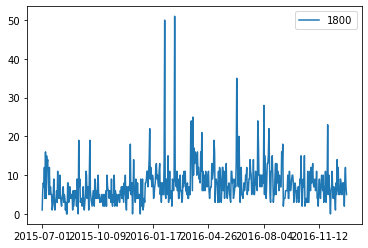

In [180]:
num=1800 #let's look at some other data set samples too while we're at it
data = df.iloc[num][1:].to_frame()
data.plot(logy=False)
data

In [181]:
# let's try a rolling average and remove outliers above 1.5 stds
data.columns = ['visits']
data['mean']=data.rolling(50,min_periods=1).mean()
std_mult=1.5
data.loc[data.visits-data.visits.mean() >= std_mult*data.visits.std(), 'visits']\
    =data.loc[data.visits-data.visits.mean() >= std_mult*data.visits.std(), 'mean']

In [92]:
data['mean'].values[1:4]

array([3.5, 5. , 5.5])

<AxesSubplot:>

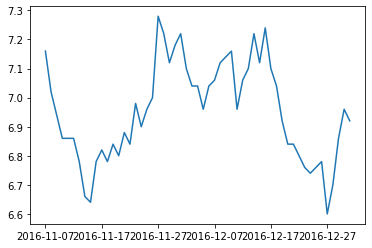

In [182]:
# train/test split
train_ratio=0.9
train, test = data['mean'][:int(train_ratio*len(data))],\
   data['mean'][int(train_ratio*len(data)):]

#use df here because pd offers some nice features for stats
# train = df.iloc[num][1:].to_frame() 

test.plot(logy=False)

In [ ]:
# the data is far less noisey now. Let's go ahead and fit our model

In [183]:
import pmdarima as pm

train_dates=df.iloc[num][1:].index[:int(train_ratio*len(wiki_page_df))]
test_dates=df.iloc[num][1:].index[int(train_ratio*len(wiki_page_df)):]

#use auto_arima to loop through p,q,d and find optimal values by minimising the AIC
model = pm.auto_arima(train.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal )
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-154.694, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69.699, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-93.689, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-82.542, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-70.247, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-168.231, Time=0.41 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-155.028, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-167.806, Time=0.45 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-168.389, Time=0.40 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-165.544, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-166.288, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-166.593, Time=0.49 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-165.552, Time=0.49 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-176.519, Time=0.53 sec
 ARIMA(3,1,3)(0,0,0)[0]             :

In [184]:
# forecast
num_days_forecast=len(test_dates)
forecast, conf_int = model.predict(num_days_forecast,return_conf_int=True,alpha=0.05)  # 95% conf
# forecast_series = forecast.summary_frame()['mean']

#confidence interval bounds
lower_conf_int = conf_int[:,0]
upper_conf_int = conf_int[:,1]

# print(forecast.summary_frame().index)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

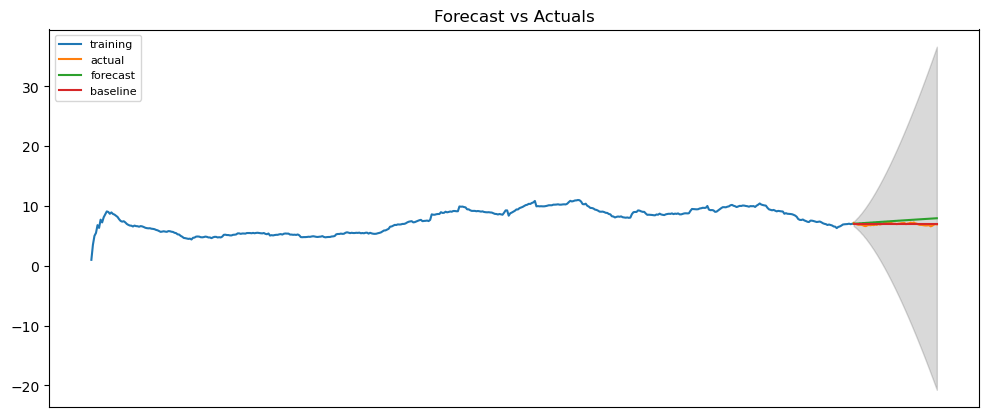

In [196]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_dates,train, label='training')
plt.plot(test_dates,test, label='actual')
plt.plot(test_dates,forecast, label='forecast')
plt.plot(test_dates,naive_y, label='baseline')
plt.fill_between(test_dates,lower_conf_int, upper_conf_int, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
# plt.ylim([0, 100])
# plt.xlim([test_dates[0], test_dates[-1]])
plt.show()

In [ ]:
# the model seems to predict a rising trend across the testing space which doesn't match up with the actuals

In [188]:
# there are many statistical measures of accuracy we can use, here we'll just look at the mean absolute error 
# on test set
from sklearn.metrics import mean_absolute_error

# we should compare to the raw testing data, which we actually haven't created yet, let's do it now
data_raw = df.iloc[num][1:].to_frame()
train_raw, test_raw = data_raw[:int(train_ratio*len(data))],\
   data_raw[int(train_ratio*len(data)):]

mae = mean_absolute_error(test_raw, forecast)
print('MAE Forecast: %.3f' % mae)

MAE Forecast: 2.740


In [195]:
# we should compare our model predictions to a baseline 'naive' model prediction
# for time-series one can use a simple 'persistence' model that assume y_t = y_t-1

# so y_t naive prediction is the last value of training data that persists
naive_y=[train[-1] for i in range(len(test))]

mae = mean_absolute_error(test_raw, naive_y)
print('MAE Forecast: %.3f' % mae)

# y_t included as 'baseline' in above plot

MAE Forecast: 2.606


In [ ]:
# wow!, so the ARIMA modelled actually performed worse than baseline!
# upon reflection, maybe one shouldn't be so surprised. The data is clearly very noisey, even with averaging,
# and there is not much, if any, periodicity or trend for the model to learn.

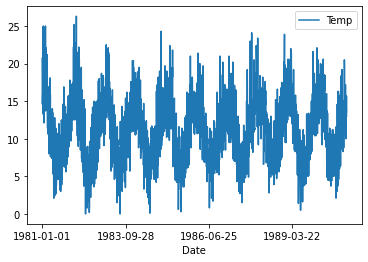

In [241]:
# let's try a different data set this time, one which our models are more likely to perform well on
# we'll use a very basic dataset of minimum daily temperatures over 10 years (1981-1990) in the city Melbourne

temp_data = pd.read_csv(
    'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv')

ax = temp_data.plot(x="Date",y="Temp",x_compat=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
# the data is very cyclical, as one might expect. This should be easier to forecast. Fb's Prophet is especially good 
# with periodic data so let's try that

In [270]:
# let's try Prophet this time.

#test/train split
train_end=len(temp_data)-365 #leave final year as test set
train_temp, test_temp = temp_data[:train_end],temp_data[train_end:]

X = pd.DataFrame(index=range(0,len(train_temp)))
X['ds'] = train_temp.Date.values
X['y'] = train_temp.Temp.values
# X.tail()
future_dates = pd.DataFrame(test_temp.Date)
future_dates.columns = ['ds']

In [271]:
from prophet import Prophet

model = Prophet(yearly_seasonality=True,weekly_seasonality=False,daily_seasonality=False) #yearly cycles
model.fit(X)
future_pred = model.predict(future_dates)
future_pred.head()

Initial log joint probability = -127.965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5784.55   0.000740958       65.6161      0.5205      0.5205      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122        5785.1   0.000236114       122.304   1.937e-06       0.001      201  LS failed, Hessian reset 
     199       5785.37   1.42458e-06       49.7111      0.7427      0.7427      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       5785.48   0.000816624       245.706    8.93e-06       0.001      398  LS failed, Hessian reset 
     299       5785.57   3.43118e-06       75.8122      0.8828      0.8828      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        5785.6   8.24079e-06       60.3327           1           1      585   
    Iter      log pro

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1990-01-01,11.400098,11.112603,18.482308,11.400098,11.400098,3.402484,3.402484,3.402484,3.402484,3.402484,3.402484,0.0,0.0,0.0,14.802581
1,1990-01-02,11.399897,11.247079,18.314911,11.399897,11.399897,3.465322,3.465322,3.465322,3.465322,3.465322,3.465322,0.0,0.0,0.0,14.865218
2,1990-01-03,11.399696,11.253485,18.512098,11.399696,11.399696,3.525946,3.525946,3.525946,3.525946,3.525946,3.525946,0.0,0.0,0.0,14.925642
3,1990-01-04,11.399495,11.389061,18.509425,11.399495,11.399495,3.583553,3.583553,3.583553,3.583553,3.583553,3.583553,0.0,0.0,0.0,14.983048
4,1990-01-05,11.399294,11.668558,18.511802,11.399294,11.399294,3.637400,3.637400,3.637400,3.637400,3.637400,3.637400,0.0,0.0,0.0,15.036694


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

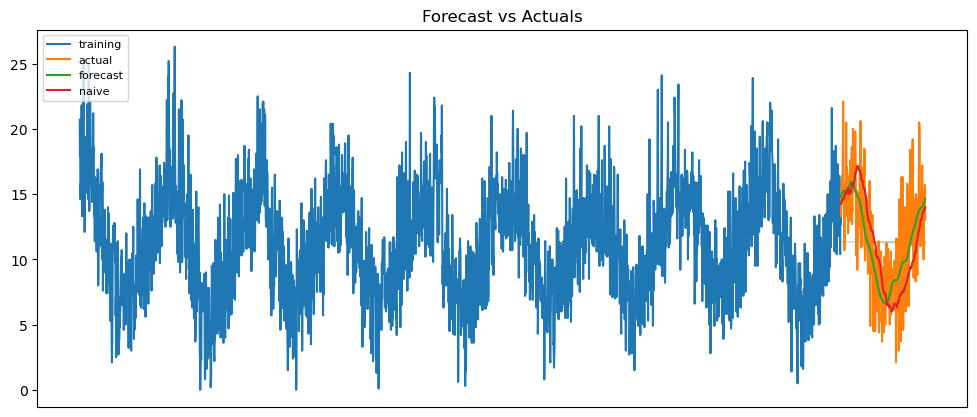

In [278]:
y_pred = future_pred['yhat'].values
lower_conf_int=future_pred['trend_lower'].values
upper_conf_int=future_pred['trend_upper'].values

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_temp.Date.values,train_temp.Temp.values, label='training')
plt.plot(test_temp.Date.values,test_temp.Temp.values, label='actual')
plt.plot(test_temp.Date.values,y_pred, label='forecast')
plt.plot(test_temp.Date.values,train_temp_av_penul, label='naive')
plt.fill_between(test_temp.Date.values,lower_conf_int, upper_conf_int, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
# plt.ylim([0, 100])
# plt.xlim([test_dates[0], test_dates[-1]])
plt.show()

In [253]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_temp.Temp.values, y_pred)
print('MSE: %.3f' % mse)

MSE: 6.349


<AxesSubplot:>

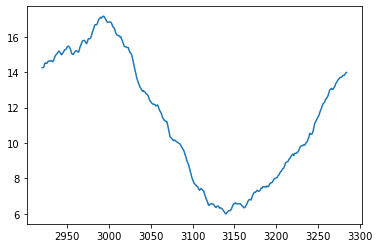

In [277]:
# compare to baseline 'naive' model
# let's use a seasonal persistence model such that previous one-year season averaged and used as persisted forecast

# average over training data
train_temp_av=train_temp.Temp.rolling(50,min_periods=1).mean()
train_temp_av_penul=train_temp_av[(len(train_temp_av)-365):] #take penultimate year of train data as persistence
train_temp_av_penul.plot()
# now we have an average of the penultimate year of training which we'll persist for the 'naive' forecast

In [280]:
mse = mean_squared_error(test_temp.Temp.values, train_temp_av_penul)
print('MSE: %.3f' % mse)

MSE: 9.276


In [ ]:
#nice! We've produced a model that clearly performs better on unseen data than a 'naive' baseline model does
#therefore our model probably has some predictive power!
#However we've used a very simple dataset with the expectations of providing a lot of predictive power.
#In the next notebook we'll try something harder and see if we can still produce a useful model.